### Data downloaded from https://simplemaps.com/data/us-cities

In [92]:
import pandas as pd
import requests
import json 
import numpy as np
import matplotlib.pyplot as pl

In [226]:
import os
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, Point

### Finding driving distance
We use Open Source Routing Machine (OSRM) api to calculate this. 

http://project-osrm.org/docs/v5.24.0/api/?language=Python#general-options

In [341]:
def distance_between(loc1,loc2):

    """
    input:
        loc1: source location (lat,long)
        loc2: destination location (lat,long)
    output:
        distance: road distance in Km
        duration: time in mins
    """

    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{loc1[1]},{loc1[0]};{loc2[1]},{loc2[0]}?overview=false""")
    # print(r.content)
    try: 
        content = json.loads(r.content)['routes'][0]
    except: 
        print(r.content)
        return False
    distance,duration = content['distance'],content['duration']

    return distance/1000, duration/60


In [281]:
def get_city_data():
    final_file = 'cities_data/simplemaps_uscities_basicv1.76/uscitites_clean.csv'
    if os.path.isfile(final_file):
        with open(final_file,'rb') as f:
            data = pickle.load(f)
        return data
    
    file_name = 'cities_data/simplemaps_uscities_basicv1.76/uscities.csv'
    city_data = pd.read_csv(file_name)
    required_cols = ['city','state_id','state_name','county_name','lat','lng','population','density']
    city_data_filtered = city_data.filter(required_cols,axis=1)
    with open(final_file,'wb') as f:
        pickle.dump(city_data_filtered,f)
    return city_data_filtered

In [282]:
city_data = get_city_data()

In [419]:
city_data.head()

,city,state_id,state_name,county_name,lat,lng,population,density
0,New York,NY,New York,Queens,40.6943,-73.9249,18972871,10768.2
1,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
2,Chicago,IL,Illinois,Cook,41.8375,-87.6866,8595181,4576.6
3,Miami,FL,Florida,Miami-Dade,25.7840,-80.2101,5711945,4945.7
4,Dallas,TX,Texas,Dallas,32.7935,-96.7667,5668165,1522.2


In [420]:
loc1= (city_data.loc[city_data['city']=="Santa Barbara"][['lat','lng']]).values[0]
loc2 = (city_data.loc[city_data['city']=="Burbank"][['lat','lng']]).values[0]
print(loc1,loc2)
distance_between(loc1,loc2)

[  34.4285 -119.7202] [  34.1879 -118.3235]


(146.6678, 109.50333333333333)

### US state grid

In [401]:

def state_polygon(state_name):
    """Returns Polygon of a US state

    Args:
        state_name (str): US state name

    Returns:
        polygon: Polygon for the state boundary
    """
    boundaries = pd.read_csv('cities_data/us-state-boundaries.csv',sep=';')
    assert state_name in boundaries['name'].values, "State not in the list"
    
    boundaries = boundaries.filter(['name','St Asgeojson'],axis=1)
    state = json.loads((boundaries.loc[boundaries['name']==state_name]).values[0][1])
    polygon = Polygon(state['coordinates'][0][0])
    return polygon

def state_grid(state_name,resolution):
    """creates grid of points inside the state

    Args:
        state_name (str): name of the US state
        resolution (float): distance resolution for the grid (units of miles)
    output:
        valid_points: list of (latitude,longitude) of points inside the state
    """

    polygon = state_polygon(state_name)
    

    ## Creating grid points inside the state
    x_min,y_min,x_max,y_max = polygon.bounds
    lat_dist_per_degree = 111/1.6 #in miles
    long_dist_per_degree = np.cos((y_min+y_max)*0.5)*111/1.6 #in miles
    resolution_lat = resolution/lat_dist_per_degree
    resolution_long = resolution/long_dist_per_degree
    gridx_points = np.arange(x_min,x_max,resolution_long)
    gridy_points = np.arange(y_min,y_max,resolution_lat)
    # print(grid_points[0].flatten(),grid_points[1].flatten())
    valid_points = []
    invalid_points = []
    for x in gridx_points:
        for y in gridy_points:
            # print(Point(x,y).within(polygon))
            if Point(x,y).within(polygon):
                valid_points.append((x,y))
            else:
                invalid_points.append((x,y))
    return valid_points, polygon

In [402]:
CA_grid, CA_polygon = state_grid('California',25)

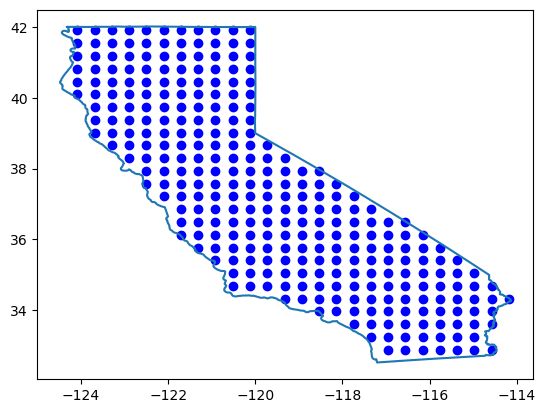

In [506]:
colors = ['blue','red']
pl.plot(*CA_polygon.exterior.xy)
[pl.scatter(p[0],p[1],color='blue') for p in CA_grid]
# [pl.scatter(*p,color='red') for p in invalid_points]



In [404]:
len(CA_grid) #total number of grid points

301

## Driving distance to cities

In [525]:
cities = (city_data[city_data['state_name']==state_name].reset_index(drop=True)).copy(deep=True)
cities.sort_values(by='population',ascending=False,inplace=True)
population_threshold = 80000
cities = cities.loc[cities['population']>population_threshold]

In [526]:
cities

,city,state_id,state_name,county_name,lat,lng,population,density
0,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
1,San Francisco,CA,California,San Francisco,37.7558,-122.4449,3290197,7199.4
2,San Diego,CA,California,San Diego,32.8313,-117.1222,3084174,1675.9
3,Riverside,CA,California,Riverside,33.9381,-117.3949,2022285,1557.0
4,Sacramento,CA,California,Sacramento,38.5677,-121.4685,1924167,1971.3
...,...,...,...,...,...,...,...,...
111,Redwood City,CA,California,San Mateo,37.5025,-122.2253,83905,1687.6
112,Alhambra,CA,California,Los Angeles,34.0840,-118.1355,83174,4275.8
113,Madera,CA,California,Madera,36.9630,-120.0778,82772,1536.8
114,Lakewood,CA,California,Los Angeles,33.8471,-118.1222,82419,3272.3


In [435]:
aa = [0,2,1]
f = lambda x: aa[x]
f(2)

1

In [533]:
(np.arange(0,10,1)<5) * (np.arange(0,10,1)<6)

array([ True,  True,  True,  True,  True, False, False, False, False,
       False])

In [696]:
def distance_from_cities(lat,lng,radii=None):
    """Generate driving distance of a point from major cities in a state

    Args:
        lat (float): latitude of the location 
        lng (float): longitude of the location
        radii (float, optional): Threshold for the distance in miles. Defaults to None. This is obsolete in the current version

    Returns:
        distance_list: distance of to all cities within the radii
        population_list: population of cities within the radii
    """
    distance_list = []
    population_list = []
    city_name_list = []
    city_loc_list = []
    totol_pop = 0

    if radii is None:
        radii = 100000000 # some random value which is not possible in physical scenario
    lat_radii = radii/(111/1.6) # in miles
    lng_radii = abs(radii/(111*np.cos(lat)/1.6)) #in miles
    
    city_locs = cities[['lng','lat']].values
    city_names = cities['city'].values
    city_pop = cities['population'].values
    
    
    dist_in_degrees = np.abs(city_locs - np.array([lng,lat]).reshape((1,2)))
    dist_in_degrees = np.sum(np.abs(dist_in_degrees[:]),axis=-1)    
    sorted_indices = dist_in_degrees.argsort()

    # sorting cities according to the distance from the location
    city_locs = city_locs[sorted_indices]
    city_names = city_names[sorted_indices]
    city_pop = city_pop[sorted_indices]

    # for index,city in cities.iterrows():
    for i,city in enumerate(city_locs):

        city_lng,city_lat = city[0],city[1]
        result = distance_between((lat,lng),(city_lat,city_lng))
        if not result:
            return False
        else:
            dist,_ = result
        distance_list.append(dist)
        city_loc_list.append((city_lat,city_lng))
        city_name_list.append(city_names[i])
        population_list.append(city_pop[i])
        totol_pop += population_list[-1]
        if totol_pop > 1000000:
            break
    
    index = list(range(len(distance_list)))
    index = sorted(index,key=lambda x:distance_list[x])
    distance_list = [distance_list[x] for x in index]
    population_list = [population_list[x] for x in index]
    city_loc_list = [city_loc_list[x] for x in index]
    city_name_list = [city_name_list[x] for x in index]

    return distance_list, population_list, city_name_list, city_loc_list

In [601]:
dist_list_100, pop_list_100,name_list_100,loc_list_100 = distance_from_cities(locations[0][0],locations[0][1],radii=100)
locations[0],loc_list_100,distance_between(locations[0],(37.4001, -122.0796))

(array([  37.4051763, -122.0847692]),
 [(37.4001, -122.0796),
  (37.3836, -122.0255),
  (37.3646, -121.968),
  (37.5025, -122.2253),
  (37.3012, -121.848),
  (37.5265, -121.9843),
  (37.6328, -122.0766)],
 (1.416, 3.1533333333333333))

In [571]:
locations[100]

array([  35.51502409, -120.66950481])

In [570]:
dist_list_100

[243.98489999999998, 366.4234, 428.67629999999997]

In [414]:
state_name = 'California' # state to focus on
locations,state_polygon = state_grid(state_name,resolution=25) # change this to change the dataset


In [450]:
locations[100],len(locations)

((-120.9140352674987, 36.1324356038088), 301)

In [602]:
# generating locations list
loc_data = pd.read_csv('CA_Grid_dataframe_with_existing_solar_farms.csv')
locations = loc_data.loc[loc_data['State']=='CA'][['Latitude','Longitude']].values


In [605]:
len(locations)

4944

In [644]:
# Generate a dataframe for a list of locations

radii = 50 #in mile
if not df_list: 
    df_list= [] 
    df = pd.DataFrame({'lng':[],'lat':[],'number of cities':[],'total population':[],'min distance':[],'max distance':[],'name of the nearest city':[],'coordinates of the nearest city (lat,lng)':[],'distance list':[],'population list':[],'cities name':[],'cities locations':[]})
else:
    df = df_list[-1].copy(deep=True)
nearest_dist = 0
nearest_city = ''
for i,loc in enumerate(locations[len(df):]):
    #loc[0] is lat and lat[1] is lng
    print(loc)
    # df['drivin radii'].append(radii)
    result = distance_from_cities(loc[0],loc[1],radii=radii)
    if not result:
        df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
            'name of the nearest city':None,
            'coordinates of the nearest city (lat,lng)':None,
            'distance list':[],'population list':[],'cities name':[],'cities locations':[]},ignore_index=True)
    else:
        dist_list, pop_list, name_list, loc_list = result
        city_count = len(dist_list)
        population = np.sum(pop_list)

        if city_count== 0:
            min_distance = None
            max_distance = None
            name_of_the_nearest_city = None
            coordinates = None
        else:
            min_distance = dist_list[0]
            max_distance = dist_list[-1]
            name_of_the_nearest_city = name_list[0]
            coordinates = loc_list[0]

        # print([loc[0],loc[1],radii,city_count,population])

        df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,
        'name of the nearest city':name_of_the_nearest_city,
         'coordinates of the nearest city (lat,lng)':coordinates,
        'distance list':dist_list,'population list':pop_list,'cities name':name_list,'cities locations':loc_list},ignore_index=True)
    
    if (i+1)%100 == 1:
        df_list.append(df.copy(deep=True))

[  35.27940088 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.23622    -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.33478064 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.43334128 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.53190191 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.63046255 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.72902319 -119.68578953]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -119.57705513]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.30818814 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.23622    -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.33478064 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.43334128 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.53190191 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.63046255 -119.57705513]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -119.46832073]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.30818814 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.9981126  -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.23622    -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.33478064 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.43334128 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.53190191 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.63046255 -119.46832073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.23622    -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.33478064 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.43334128 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.53190191 -119.35958632]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.23622    -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.33478064 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.43334128 -119.25085192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.23622    -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.33478064 -119.14211752]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -119.03338311]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  34.09667323 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.23622    -119.03338311]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.23622    -118.92464871]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13765936 -118.81591431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126 -118.7071799]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977 -118.7071799]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498 -118.7071799]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349 -118.7071799]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03909873 -118.7071799 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -118.5984455 ]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.01250622 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.40674877 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.50530941 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.9981126 -118.5984455]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977 -118.5984455]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498 -118.5984455]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349 -118.5984455]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -118.5984455 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -118.48971109]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  32.91394559 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.30818814 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.40674877 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.50530941 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.9981126  -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.94053809 -118.48971109]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -118.38097669]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.30818814 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.40674877 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.70243069 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.84197745 -118.38097669]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -118.27224229]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.70243069 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.74341682 -118.27224229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64485618 -118.16350788]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -118.05477348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54629554 -117.94603908]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.4477349  -117.83730467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34917427 -117.72857027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.25061363 -117.61983587]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15205299 -117.51110146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -117.40236706]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.05349235 -117.29363266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95493172 -117.18489825]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85637108 -117.07616385]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.75781044 -116.96742944]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.6592498  -116.85869504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -116.74996064]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56068917 -116.64122623]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46212853 -116.53249183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.36356789 -116.42375743]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.26500726 -116.31502302]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61826368 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.16644662 -116.20628862]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -116.09755422]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.06788598 -115.98881981]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.96932534 -115.88008541]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275 -115.771351 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126 -115.771351 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977 -115.771351 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.87076471 -115.771351  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275 -115.6626166]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126 -115.6626166]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977 -115.6626166]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.77220407 -115.6626166 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275 -115.5538822]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126 -115.5538822]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977 -115.5538822]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.67364343 -115.5538822 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.57508279 -115.44514779]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -115.33641339]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47652216 -115.22767899]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.37796152 -115.11894458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27940088 -115.01021018]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.18084025 -114.90147578]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.71682431 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.11106686 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30818814 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.40674877 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.08227961 -114.79274137]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.2096275  -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.50530941 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.88515833 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.98371897 -114.68400697]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81538495 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.01250622 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.60387005 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.70243069 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80099132 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.89955196 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.7865977  -114.57527257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.91394559 -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.9981126  -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.09667323 -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49091578 -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.58947642 -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68803706 -114.46653816]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -114.35780376]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -114.35780376]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.39235515 -114.35780376]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.19523387 -114.24906935]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -114.24906935]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.29379451 -114.14033495]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/1888298407.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


In [651]:
print(len(locations),len(df))

4944 4944


In [668]:
df.head()

,Longitude,Latitude,number of cities,total population,min distance,max distance,name of the nearest city,"coordinates of the nearest city (lat,lng)",distance list,population list,cities name,cities locations,total population
0,-122.084769,37.405176,7.0,2573421.0,1.4160,35.0924,Mountain View,"(37.4001, -122.0796)","[1.416, 7.956300000000001, 14.0357, 19.431, 29...","[82409, 155550, 127922, 83905, 1729879, 231502...","[Mountain View, Sunnyvale, Santa Clara, Redwoo...","[(37.4001, -122.0796), (37.3836, -122.0255), (...",NaN
1,-122.271529,37.847173,5.0,4054205.0,3.3332,21.9418,Berkeley,"(37.8722, -122.276)","[3.3331999999999997, 9.5241, 16.0637, 21.7972,...","[119607, 437548, 115677, 3290197, 91176]","[Berkeley, Oakland, Richmond, San Francisco, S...","[(37.8722, -122.276), (37.7904, -122.2166), (3...",NaN
2,-121.560230,37.154450,2.0,1844340.0,33.7577,46.0568,Gilroy,"(37.0046, -121.5854)","[33.7577, 46.0568]","[114461, 1729879]","[Gilroy, San Jose]","[(37.0046, -121.5854), (37.3012, -121.848)]",NaN
3,-122.086832,38.006981,4.0,1082992.0,11.8221,37.5308,Concord,"(37.9722, -122.0016)","[11.8221, 20.3322, 32.7919, 37.530800000000006]","[640270, 181882, 115677, 145163]","[Concord, Vallejo, Richmond, Fairfield]","[(37.9722, -122.0016), (38.1125, -122.2342), (...",NaN
4,-122.142635,38.089888,4.0,1082992.0,16.3706,34.9680,Vallejo,"(38.1125, -122.2342)","[16.3706, 22.8395, 31.6755, 34.968]","[181882, 640270, 145163, 115677]","[Vallejo, Concord, Fairfield, Richmond]","[(38.1125, -122.2342), (37.9722, -122.0016), (...",NaN


In [669]:
# with open('cities_data.pd','wb') as f:
#     pickle.dump(df,f)

In [670]:
# df.to_csv('cities_data.csv')

### Merging cities data with the final database

In [661]:
final_data = pd.read_csv('data_including_land_cover.csv')

In [666]:
final_data.loc[final_data['State']=='CA']

,Latitude,Longitude,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover
2,37.405176,-122.084769,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"1625 San Luis Ave, Mountain View, CA 94043, USA",5.801625e+06,1.021578e+07,1.054983e+07,0.0
3,37.847173,-122.271529,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3372 Martin Luther King Jr Way, Berkeley, CA 9...",5.308202e+06,6.235440e+06,7.062910e+06,1.0
4,37.154450,-121.560230,CA,0.000141,NaN,1.0,0.0,0.0,0.0,"16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA",4.974155e+06,4.974155e+06,9.388313e+06,1.0
5,38.006981,-122.086832,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"150 Nardi Ln, Martinez, CA 94553, USA",4.974155e+06,4.974155e+06,6.235440e+06,0.0
6,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7986,34.293795,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0
7987,34.392355,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0
7988,34.195234,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0
7989,34.293795,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0


In [690]:
df = pd.read_csv('cities_data.csv',index_col=0)

In [702]:
df = df[['Longitude','Latitude','min distance']]
df.head()

,Longitude,Latitude,min distance
0,-122.084769,37.405176,1.4160
1,-122.271529,37.847173,3.3332
2,-121.560230,37.154450,33.7577
3,-122.086832,38.006981,11.8221
4,-122.142635,38.089888,16.3706


In [699]:
final_data_city = final_data.join(df.set_index(['Latitude','Longitude']),on=['Latitude','Longitude'])

In [732]:
final_data_city.loc[(final_data_city['Latitude']<38.089889).values * (final_data_city['Latitude']>38.089887).values]

,Latitude,Longitude,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance
6,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0,16.3706


In [742]:
final_data_city.rename(columns={'min distance':'min distance to city (in miles)'},inplace=True)

In [744]:
final_data_city.to_csv('data_LandCover_Cities.csv',index=False)

In [883]:
test = pd.read_csv('data_LandCover_Cities.csv')

In [884]:

test.loc[test['State']=='CA']

,Latitude,Longitude,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance to city (in miles)
2,37.405176,-122.084769,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"1625 San Luis Ave, Mountain View, CA 94043, USA",5.801625e+06,1.021578e+07,1.054983e+07,0.0,1.4160
3,37.847173,-122.271529,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3372 Martin Luther King Jr Way, Berkeley, CA 9...",5.308202e+06,6.235440e+06,7.062910e+06,1.0,3.3332
4,37.154450,-121.560230,CA,0.000141,NaN,1.0,0.0,0.0,0.0,"16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA",4.974155e+06,4.974155e+06,9.388313e+06,1.0,33.7577
5,38.006981,-122.086832,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"150 Nardi Ln, Martinez, CA 94553, USA",4.974155e+06,4.974155e+06,6.235440e+06,0.0,11.8221
6,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0,16.3706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7986,34.293795,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,240.5314
7987,34.392355,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,269.8006
7988,34.195234,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,222.2860
7989,34.293795,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,243.1461


### Analyzing dataset

In [885]:
CA_data = test.loc[test['State']=='CA']

In [910]:
lats = CA_data['Latitude'].values.copy()
lngs = CA_data['Longitude'].values.copy()
lats_solar_farm = CA_data.loc[CA_data['panel.area']>0.01]['Latitude'].values.copy()
lngs_solar_farm = CA_data.loc[CA_data['panel.area']>0.01]['Longitude'].values.copy()
lats_grid = CA_data.loc[np.isnan(CA_data['panel.area'])]['Latitude'].values.copy()
lngs_grid = CA_data.loc[np.isnan(CA_data['panel.area'])]['Longitude'].values.copy()

In [911]:
len(lats_solar_farm)

229

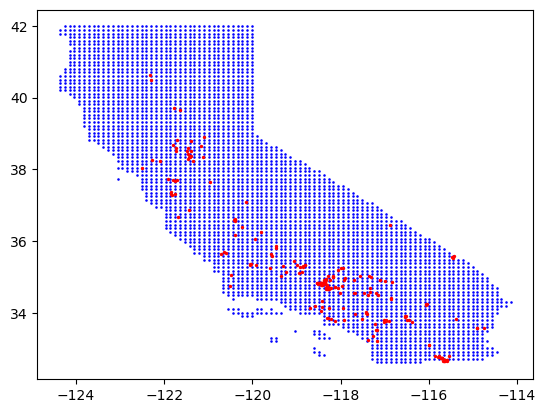

In [912]:
pl.scatter(lngs_grid,lats_grid,color='blue',s=0.7)
pl.scatter(lngs_solar_farm,lats_solar_farm,color='red',s=2)

In [853]:
cities_distance = CA_data['min distance to city (in miles)'].values.copy()
cities_distance_solar_farms = CA_data.loc[CA_data['panel.area']>0]['min distance to city (in miles)'].values.copy()
cities_distance_grid = CA_data.loc[np.isnan(CA_data['panel.area'])]['min distance to city (in miles)'].values.copy()

In [845]:
np.any(np.isnan(cities_distance))

True

(array([548., 147.,  92.,  91.,  17.,   0.,   0.,   6.,   0.,   1.]),
 array([  0.5575 ,  32.45798,  64.35846,  96.25894, 128.15942, 160.0599 ,
        191.96038, 223.86086, 255.76134, 287.66182, 319.5623 ]),
 <BarContainer object of 10 artists>)

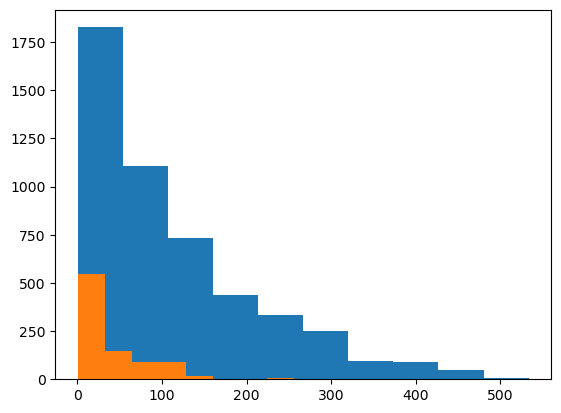

In [846]:
pl.hist(cities_distance,bins=10)
pl.hist(cities_distance_solar_farms,bins=10)

In [847]:
cities_lat = cities['lat'].values.copy()
cities_lng = cities['lng'].values.copy()

Text(0.5, 1.0, 'Cities with min. population 88000 in CA')

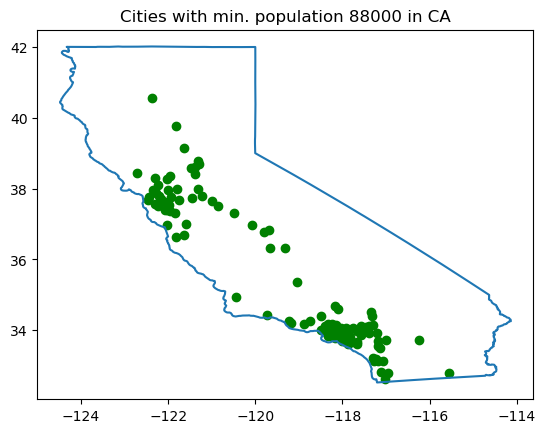

In [848]:
pl.plot(*CA_polygon.exterior.xy)
pl.scatter(cities_lng,cities_lat,color='green')
pl.title('Cities with min. population 88000 in CA')

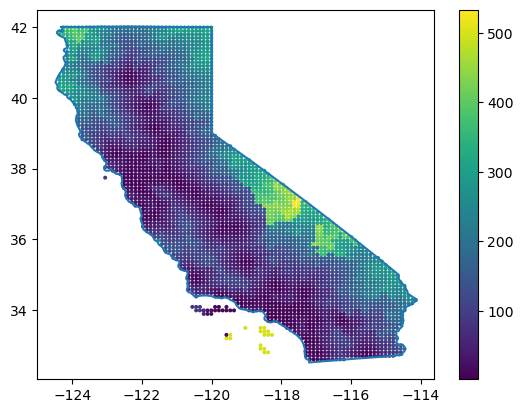

In [856]:
aa = np.meshgrid(lngs[:],lats[:])
pl.plot(*CA_polygon.exterior.xy) 
max_dist = np.max(cities_distance)
cities_distance_grid[np.isnan(cities_distance_grid)]=500
# pl.tricontour(lngs[:],lats[:],cities_distance[:])
sc = pl.scatter(lngs_grid,lats_grid,c=cities_distance_grid,s= 3.5)
pl.colorbar(sc)


In [858]:
test2 = pd.read_csv("ca_lc_city_slope_elevation.csv")

In [ ]:
tr

In [868]:

test2.loc[test2["power"]>0.01]

,lat,lon,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance to city (in miles),slope,elevation
37,39.651116,-121.648247,CA,0.024364,1.765290,20.0,0.281727,0.0,0.0,"Student Health Clinic, Oroville, CA 95965, USA",4.974155e+06,4.974155e+06,4.974155e+06,1.0,24.6027,4,106
41,35.651108,-120.710920,CA,0.011991,0.971455,1229.0,1.631422,0.0,0.0,"3575 Mustang Springs Rd, Paso Robles, CA 93446...",4.974155e+06,4.974155e+06,4.974155e+06,1.0,102.1655,7,315
50,35.656988,-120.596400,CA,0.010924,0.898075,66.0,1.814945,0.0,0.0,"5625 CA-46, Paso Robles, CA 93446, USA",4.974155e+06,4.974155e+06,4.974155e+06,1.0,108.5896,1,281
167,38.804454,-121.719128,CA,0.016557,1.274879,29.0,0.018558,0.0,0.0,"R73J+Q8 Knights Landing, CA, USA",4.974155e+06,4.974155e+06,1.677158e+07,0.0,42.0723,0,10
200,38.888452,-121.106815,CA,0.010647,0.878875,20.0,0.221473,0.0,0.0,"VVQV+97 Auburn, CA, USA",4.974155e+06,4.974155e+06,1.677158e+07,1.0,27.4874,5,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,34.654199,-118.283380,CA,0.916495,37.506222,16.0,0.916495,0.0,0.0,"MP38+MJ Lancaster, CA, USA",4.974155e+06,4.974155e+06,4.974155e+06,1.0,15.7151,3,815
898,34.904225,-117.106231,CA,0.448031,20.522552,7.0,0.448031,0.0,0.0,"25499 Community Blvd, Barstow, CA 92311, USA",4.974155e+06,4.974155e+06,4.974155e+06,1.0,57.8358,0,663
899,34.549331,-117.466955,CA,0.058741,3.705283,4.0,0.058741,0.0,0.0,"GGXM+P6 Adelanto, CA, USA",4.974155e+06,4.974155e+06,4.974155e+06,1.0,14.5345,1,917
900,34.496376,-117.144202,CA,0.065647,4.069053,3.0,0.065647,0.0,0.0,"23755 Powhatan Rd, Apple Valley, CA 92307, USA",4.974155e+06,4.974155e+06,5.470331e+06,1.0,23.9459,0,896
